## Load data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
np.random.seed(42)

In [ ]:
categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
sales = pd.read_csv('sales_train.csv')

## Look at the data

In [ ]:
shops.head(3)

shop_name  shop_id
0  !Якутск Орджоникидзе, 56 фран        0
1  !Якутск ТЦ "Центральный" фран        1
2               Адыгея ТЦ "Мега"        2

In [ ]:
categories.head(3)

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2

In [ ]:
items.head(3)

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   

   item_category_id  
0                40  
1                76  
2                40

In [ ]:
sales.head(3)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154       999.0           1.0
1  03.01.2013               0       25     2552       899.0           1.0
2  05.01.2013               0       25     2552       899.0          -1.0

## Checking NaN

In [ ]:
shops.isna().sum(), items.isna().sum(), categories.isna().sum(), sales.isna().sum()

(shop_name    0
 shop_id      0
 dtype: int64, item_name           0
 item_id             0
 item_category_id    0
 dtype: int64, item_category_name    0
 item_category_id      0
 dtype: int64, date              0
 date_block_num    0
 shop_id           0
 item_id           0
 item_price        0
 item_cnt_day      0
 dtype: int64)

There are no NaN values

# Check common sense

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


The fact that item_cnt_day has the type float is kind of suspicios. It might be a sign of existing outliers

In [ ]:
sales[sales.item_cnt_day != round(sales.item_cnt_day)]

Empty DataFrame
Columns: [date, date_block_num, shop_id, item_id, item_price, item_cnt_day]
Index: []

There are no float values so let's transform float -> int

In [ ]:
sales.item_cnt_day = sales.item_cnt_day.astype(int)

In [ ]:
sales.describe(percentiles=[.25, .5, .75, .95]).drop(['shop_id', 'item_id'], axis = 1)

date_block_num    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  8.908532e+02  1.242641e+00
std      9.422988e+00  1.729800e+03  2.618834e+00
min      0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.990000e+02  1.000000e+00
75%      2.300000e+01  9.990000e+02  1.000000e+00
95%      3.100000e+01  2.690000e+03  2.000000e+00
max      3.300000e+01  3.079800e+05  2.169000e+03

Noticing some suspicios numbers in 'min' row

In [ ]:
sales[sales.item_price <= 0]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0             1

In [ ]:
len(sales[sales.item_cnt_day < 0])

7356

There are some incorrect values in 'item_price' and 'item_cnt_day'. As a solution we can erase all the outliers or make the negative count positive assuming the minus appeard just by mistake

# Shops

In [ ]:
shops.sample(3)

shop_name  shop_id
0           !Якутск Орджоникидзе, 56 фран        0
5                  Вологда ТРЦ "Мармелад"        5
36  Новосибирск ТРЦ "Галерея Новосибирск"       36

In [ ]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


 It looks like the first word is the name of the city. Let's extract city name from shop name and see if it can help.

Also we see duplicates at indexes 0-58, 1-59 

In [ ]:
shops.iloc[0,0] = shops.iloc[0,0][1:]
shops.iloc[1,0] = shops.iloc[1,0][1:]
shops['city'] = [x.split(' ')[0] for x in shops.shop_name]
shops.sample(5)

shop_name  shop_id        city
18          Красноярск ТЦ "Июнь"       18  Красноярск
45          Самара ТЦ "ПаркХаус"       45      Самара
47        Сургут ТРЦ "Сити Молл"       47      Сургут
48  Томск ТРЦ "Изумрудный Город"       48       Томск
4       Волжский ТЦ "Волга Молл"        4    Волжский

In [ ]:
cities = pd.unique(shops['city'])
cities, len(cities)

(array(['Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
        'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
        'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
        'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
        'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
        'Ярославль'], dtype=object), 31)

We see that there are "Интернет-магазин", "Цифровой", "Выездная" which are obviously not cities. Let's leave it the way it is for now. Maybe it will not be a problem

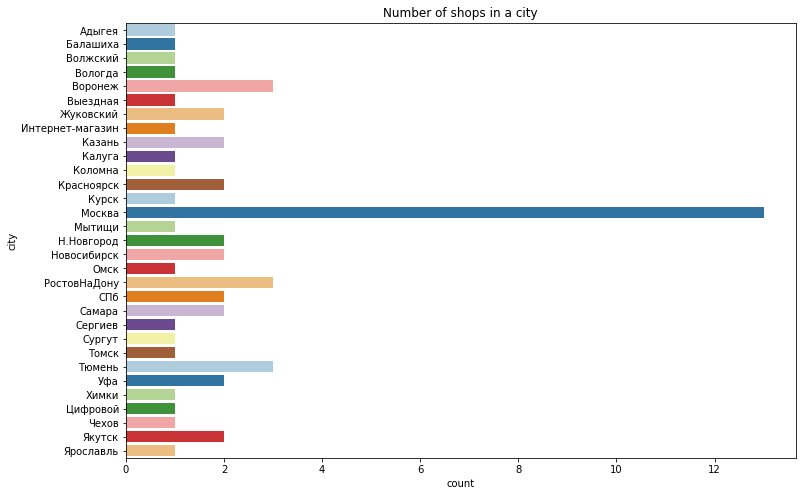

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(y="city", data=shops.iloc[2:], palette = 'Paired')
plt.title('Number of shops in a city')
plt.show()

It looks like Moscow has more shops than any other city

# Categories

In [ ]:
categories.sample(4)

item_category_name  item_category_id
20                         Игры - PS4                20
70     Подарки - Сувениры (в навеску)                70
52               Книги - Путеводители                52
49  Книги - Методические материалы 1С                49

In [ ]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [ ]:
len(pd.unique(categories['item_category_name']))

84

All the categories are unique. But there are a lot of them. If we look at the structure we'll see that most of the categories follow the pattern '1 - 2' where 2 is additional category

Let's extract category and subcategory and get rid of the words in braces as they also represent additional information which may be redundant to the model

In [ ]:
categories['cat'] = [x.split('-')[0].strip().split('(')[0].strip() for x in categories['item_category_name'] ]
categories['sub_cat'] = categories["item_category_name"].str.split(" - ").str.get(1).str.strip().fillna("none")
categories['sub_cat'] = categories['sub_cat'].str.split('(').str.get(0).str.strip()
pd.unique(categories.sub_cat)

array(['Гарнитуры/Наушники', 'PS2', 'PS3', 'PS4', 'PSP', 'PSVita',
       'XBOX 360', 'XBOX ONE', 'none', 'Прочие', 'Аксессуары для игр',
       'Цифра', 'Дополнительные издания', 'Коллекционные издания',
       'Стандартные издания', 'Live!', 'PSN', 'Windows', 'Blu-Ray',
       'Blu-Ray 3D', 'Blu-Ray 4K', 'DVD', 'Коллекционное',
       'Артбуки, энциклопедии', 'Аудиокниги', 'Аудиокниги 1С',
       'Бизнес литература', 'Комиксы, манга', 'Компьютерная литература',
       'Методические материалы 1С', 'Открытки',
       'Познавательная литература', 'Путеводители',
       'Художественная литература', 'CD локального производства',
       'CD фирменного производства', 'MP3', 'Винил', 'Музыкальное видео',
       'Подарочные издания', 'Атрибутика', 'Гаджеты, роботы, спорт',
       'Мягкие игрушки', 'Настольные игры', 'Открытки, наклейки',
       'Развитие', 'Сертификаты, услуги', 'Сувениры',
       'Сумки, Альбомы, Коврики д/мыши', 'Фигурки', '1С:Предприятие 8',
       'MAC', 'Для дома и офиса

In [ ]:
categories['sub_cat'] = categories['sub_cat'].str.replace(' 360', '')
categories['sub_cat'] = categories['sub_cat'].str.replace(' ONE', '')
categories['sub_cat'] = categories['sub_cat'].str.replace(' 3D', '')
categories['sub_cat'] = categories['sub_cat'].str.replace(' 4K', '')
categories['sub_cat'] = categories['sub_cat'].str.replace(' 1С', '')

In [ ]:
pd.unique(categories.sub_cat)

array(['Гарнитуры/Наушники', 'PS2', 'PS3', 'PS4', 'PSP', 'PSVita', 'XBOX',
       'none', 'Прочие', 'Аксессуары для игр', 'Цифра',
       'Дополнительные издания', 'Коллекционные издания',
       'Стандартные издания', 'Live!', 'PSN', 'Windows', 'Blu-Ray', 'DVD',
       'Коллекционное', 'Артбуки, энциклопедии', 'Аудиокниги',
       'Бизнес литература', 'Комиксы, манга', 'Компьютерная литература',
       'Методические материалы', 'Открытки', 'Познавательная литература',
       'Путеводители', 'Художественная литература',
       'CD локального производства', 'CD фирменного производства', 'MP3',
       'Винил', 'Музыкальное видео', 'Подарочные издания', 'Атрибутика',
       'Гаджеты, роботы, спорт', 'Мягкие игрушки', 'Настольные игры',
       'Открытки, наклейки', 'Развитие', 'Сертификаты, услуги',
       'Сувениры', 'Сумки, Альбомы, Коврики д/мыши', 'Фигурки',
       '1С:Предприятие 8', 'MAC', 'Для дома и офиса', 'Обучающие',
       'Билеты'], dtype=object)

In [ ]:
pd.unique(categories['cat'])

array(['PC', 'Аксессуары', 'Билеты', 'Доставка товара', 'Игровые консоли',
       'Игры', 'Игры Android', 'Игры MAC', 'Игры PC', 'Карты оплаты',
       'Кино', 'Книги', 'Музыка', 'Подарки', 'Программы', 'Служебные',
       'Чистые носители', 'Элементы питания'], dtype=object)

Let's change all "Игры **** " to just "Игры" to simplify the categories

In [ ]:
categories['cat'] = ['Игры' if x == 'Игры PC' or x == 'Игры Android' or x == 'Игры MAC' else x for x in categories['cat']  ]
categories.sample(10)

item_category_name  item_category_id              cat  \
40                         Кино - DVD                40             Кино   
20                         Игры - PS4                20             Игры   
13              Игровые консоли - PSP                13  Игровые консоли   
29    Игры PC - Коллекционные издания                29             Игры   
7               Аксессуары - XBOX ONE                 7       Аксессуары   
73       Программы - 1С:Предприятие 8                73        Программы   
49  Книги - Методические материалы 1С                49            Книги   
3                    Аксессуары - PS4                 3       Аксессуары   
36     Карты оплаты - Windows (Цифра)                36     Карты оплаты   
14           Игровые консоли - PSVita                14  Игровые консоли   

                   sub_cat  
40                     DVD  
20                     PS4  
13                     PSP  
29   Коллекционные издания  
7                     XBOX  
73        1С:Предприятие 8  
49  Методические материалы  
3                      PS4  
36                 Windows  
14                  PSVita

Looks nice

In [ ]:
pd.unique(categories['cat'])

array(['PC', 'Аксессуары', 'Билеты', 'Доставка товара', 'Игровые консоли',
       'Игры', 'Карты оплаты', 'Кино', 'Книги', 'Музыка', 'Подарки',
       'Программы', 'Служебные', 'Чистые носители', 'Элементы питания'],
      dtype=object)

In [ ]:
len(categories), len(pd.unique(categories.sub_cat)), len(pd.unique(categories['cat']))

(84, 51, 15)

# Items

In [ ]:
items.sample(5)

item_name  item_id  \
12135  Игромания. Выбор редакции. Call of Duty: World...    12135   
5980   R.E.M.  Part Lies Part Heart Part Truth Part G...     5980   
2561   DEEP PURPLE In Rock - 25th Anniversary Edition...     2561   
17714  Практический годовой отчет за 2014 год (+ диск...    17714   
898              1С:Школа. Окружающий мир, 1-4 кл. Тесты      898   

       item_category_id  
12135                30  
5980                 55  
2561                 56  
17714                49  
898                  77

It looks like very few item names contain valid info about the category. So we'll leave it untouched for now

In [ ]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [ ]:
len(pd.unique(items.item_name))

22170

All the names are unique. There are no duplicates

# Sales

In [ ]:
sales.sample(7)

date  date_block_num  shop_id  item_id  item_price  \
2126242  20.11.2014              22       54    11795       139.3   
1204091  04.12.2013              11       54    12477       199.0   
2462910  03.02.2015              25       12    17957       699.0   
1961285  15.09.2014              20       42     2808       999.0   
933816   02.10.2013               9       44     8924       299.0   
2330000  09.01.2015              24       18    14831       999.0   
526141   21.05.2013               4        6    18298       199.0   

         item_cnt_day  
2126242             1  
1204091             1  
2462910            -1  
1961285             1  
933816              1  
2330000             1  
526141              1

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 134.4+ MB


Let's change values in 'date' col from string to date type

In [ ]:
sales.date = pd.to_datetime(sales.date, format='%d.%m.%Y')
sales.sample()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
2123084 2014-11-01              22       31     5671      3190.0             2

In [ ]:
sales.item_price.describe(percentiles=[.25, .5, .75, .95])

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
95%      2.690000e+03
max      3.079800e+05
Name: item_price, dtype: float64

It looks like 95% of items were sold for less than 2690 RUB considering max price is ~300.000 RUB

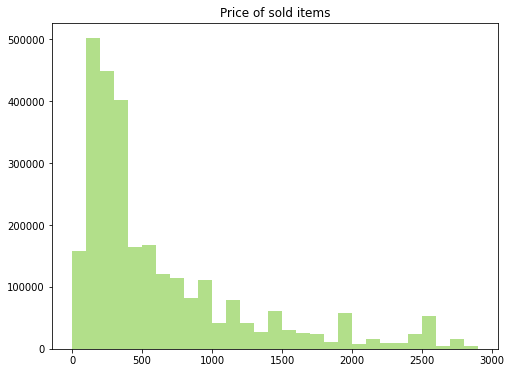

In [ ]:
plt.figure(figsize=(8,6))
colors = sns.color_palette('Paired')[2]
plt.hist(sales.item_price, color = colors, bins = list(range(0,3000, 100)))
plt.title('Price of sold items')
plt.show()

In [ ]:
sales.item_cnt_day.describe(percentiles=[.25, .5, .75, .875, .95])

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
87.5%    1.000000e+00
95%      2.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

It looks like most items were sold by <= 1 in a day and 95% were sold in less or equal than 2

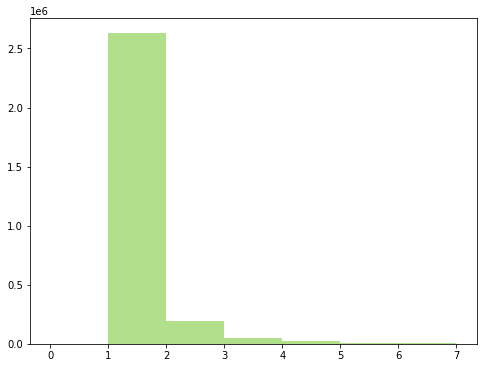

In [ ]:
plt.figure(figsize=(8,6))
colors = sns.color_palette('Paired')[2]
plt.hist(sales.item_cnt_day, color = colors, bins = list(range(0,8, 1)))
plt.show()

# Outliers

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


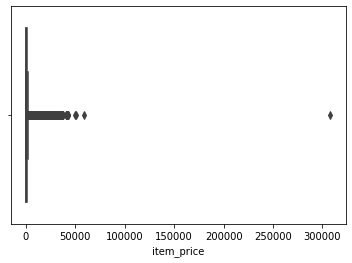

In [ ]:
sns.boxplot(sales.item_price)
plt.show()

In [ ]:
sales[sales.item_price >= 50000]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
885138  2013-09-17               8       12    11365     59200.0             1
1163158 2013-12-13              11       12     6066    307980.0             1
1488135 2014-03-20              14       25    13199     50999.0             1

In [ ]:
temp = sales.item_price.describe()
q25 = temp[4]
q75 = temp[6]
IQR = q75 - q25
Upper_bound = (1.5 * IQR) + q75
Lower_bound= q25 - (1.5 * IQR)

In [ ]:
sales[sales.item_price > Upper_bound ]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
37      2013-01-02               0       25     2719      2699.0             1
38      2013-01-12               0       25     2719      2699.0             1
158     2013-01-03               0       25     2253      2199.0             1
159     2013-01-18               0       25     2253      2199.0             1
160     2013-01-26               0       25     2254      2199.0             1
...            ...             ...      ...      ...         ...           ...
2935782 2015-10-30              33       25     7134      3599.0             1
2935802 2015-10-19              33       25     7583      2150.0             1
2935804 2015-10-29              33       25     7610      2890.0             1
2935813 2015-10-01              33       25     7640      4040.0             1
2935822 2015-10-17              33       25     7632      2310.0             1

[258942 rows x 6 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


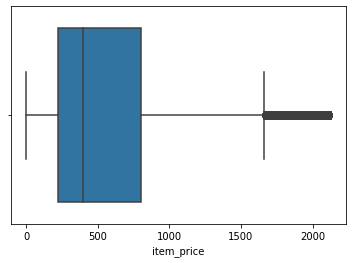

In [ ]:
sns.boxplot(sales[sales.item_price <= Upper_bound].item_price)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


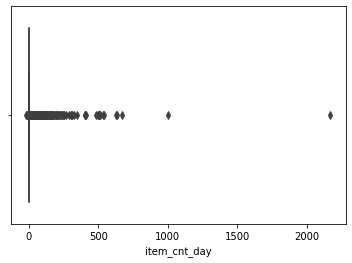

In [ ]:
sns.boxplot(sales.item_cnt_day)

In [ ]:
sales[sales.item_cnt_day > 20].groupby('date_block_num').groups.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

# Merge items with categories in order to proceed the analysis

In [ ]:
items_with_categories = pd.merge(items,categories, on = 'item_category_id')

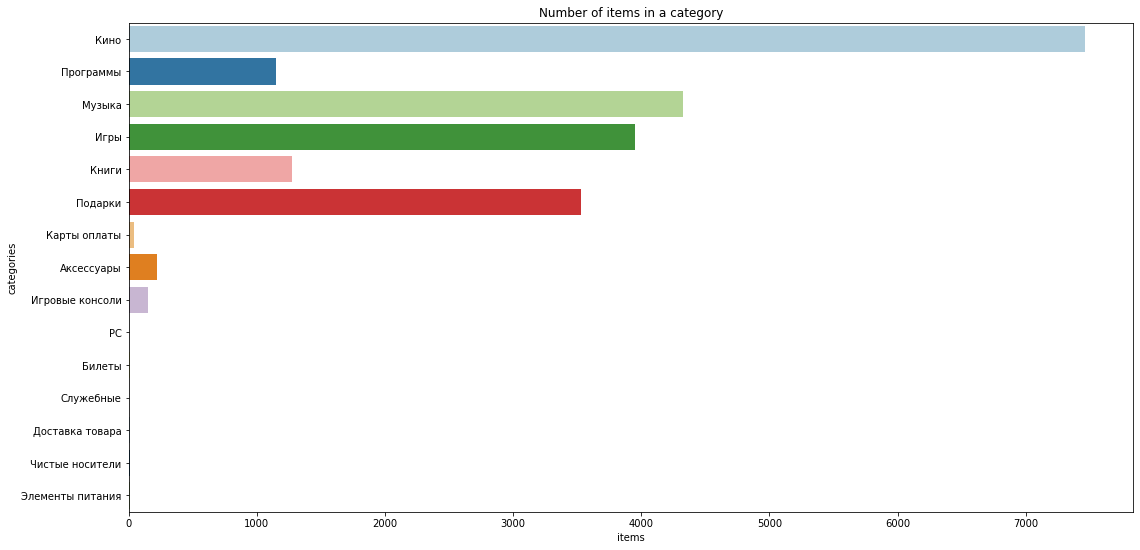

In [ ]:
fig = plt.figure(figsize=(18,9))
chart = sns.countplot(y="cat", data=items_with_categories, palette = 'Paired')
chart.set(xlabel='items', ylabel='categories')
plt.title('Number of items in a category')
plt.show()

It looks like most items from items dataset are labeled as "Кино". Some categories are represented by a very limited amount of items. Maybe it would make sense to unite them into one category like 'other' for simplification later

# Total sells in a city

In [ ]:
sales_shop = pd.merge(sales,shops, on = 'shop_id')
cities_total = sales_shop.groupby('city')['item_cnt_day'].sum()

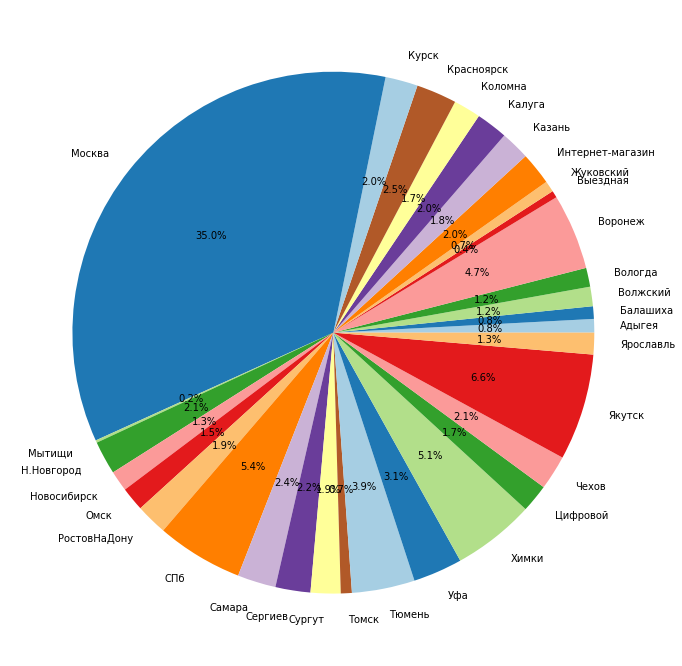

In [ ]:
plt.figure(figsize=(12,12))
colors = sns.color_palette('Paired')[:len(cities_total)]
plt.pie(cities_total, labels = cities_total.index, autopct = '%0.1f%%', colors = colors)
plt.show()

As you can see from the pieplot Moscow is the leader. But Moscow also has much more shops than other cities. So let's take a look at the average count of items 

In [ ]:
shops_count = pd.DataFrame(shops.groupby('city')['shop_name'].count()).reset_index(level = [0])
cities_total =  pd.DataFrame(cities_total).reset_index(level = [0])
cities_total = pd.merge(shops_count, cities_total, on = 'city')
cities_total.columns = ['city', 'shop_count', 'item_cnt_month']
cities_total['mean'] = cities_total.item_cnt_month/cities_total.shop_count
cities_total.head()

city  shop_count  item_cnt_month          mean
0    Адыгея           1           30620  30620.000000
1  Балашиха           1           28355  28355.000000
2  Волжский           1           43942  43942.000000
3   Вологда           1           42762  42762.000000
4   Воронеж           3          171142  57047.333333

# Average amount of sold items in a city

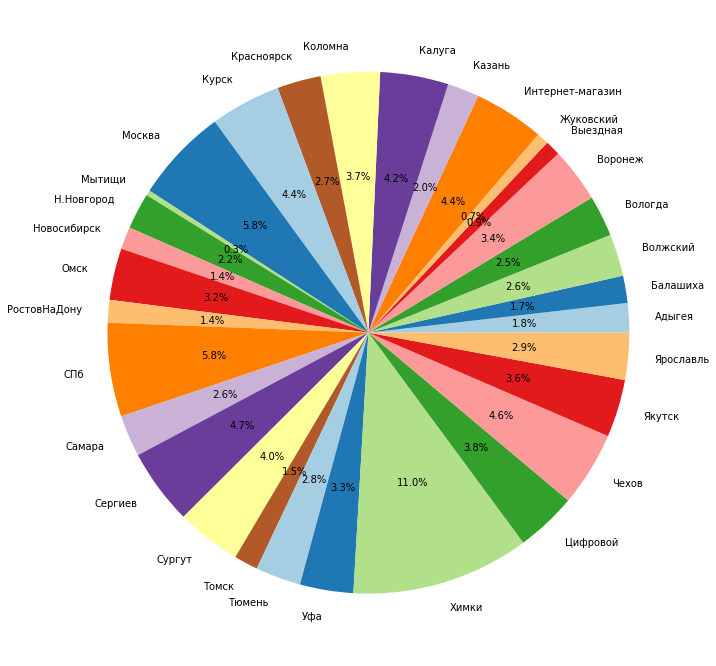

In [ ]:
plt.figure(figsize=(12,12))
colors = sns.color_palette('Paired')[:len(cities_total)]
plt.pie(cities_total['mean'], labels = cities_total.city, autopct = '%0.1f%%', colors = colors)
plt.show()

From this pieplot Himky has more sold items in average. It has only one shop. 

Let's look at the amount of sold items per each shop

# Total sells in shops

In [ ]:
shops_total = sales_shop.groupby('shop_name')['item_cnt_day'].sum()

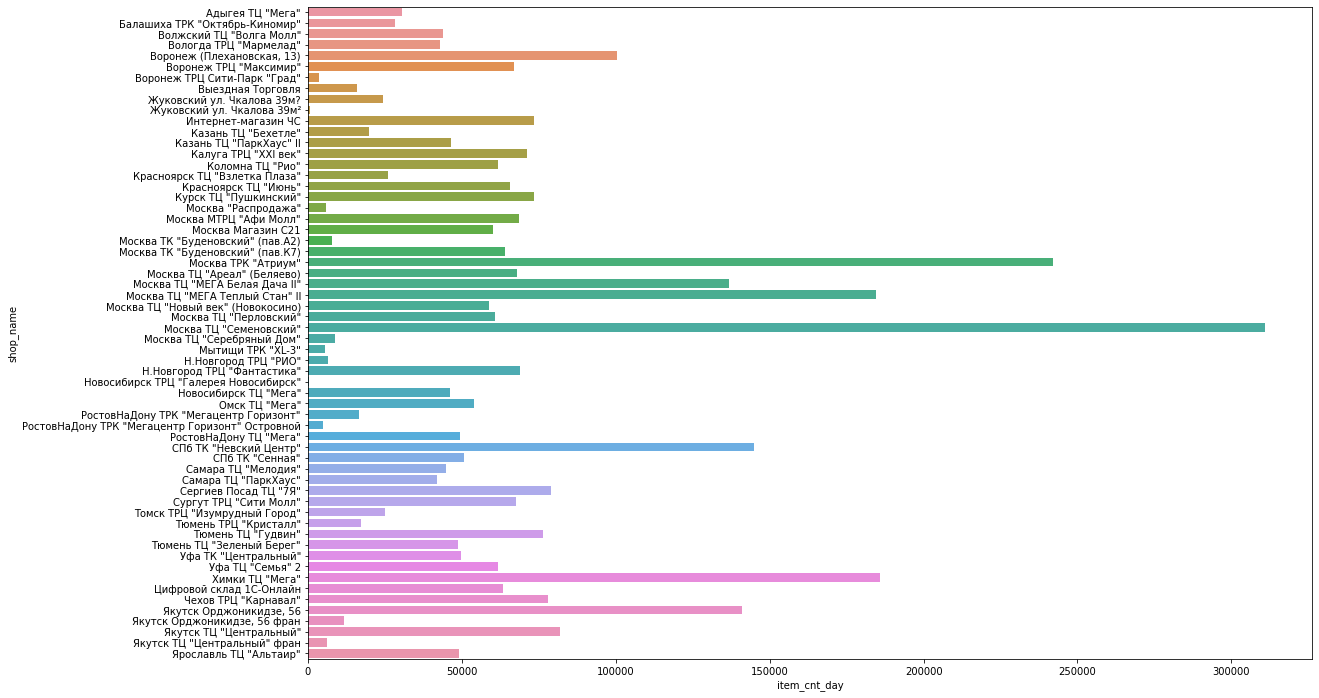

In [ ]:
fig = plt.figure(figsize=(18,12))
chart = sns.barplot(x = shops_total, y = shops_total.index)
plt.show()

We already saw the distribution of item_cnt_day.
Let's look at the distribution of sold items in a month

In [ ]:
fet = pd.DataFrame(sales.groupby([sales.date_block_num, 'item_id'])['item_cnt_day'].sum())
fet.index.names = ['month', 'item_id']
fet.columns = ['item_cnt_month']
fet = fet.reset_index(level = [0,1])

In [ ]:
fet[['item_cnt_month']].describe([.25, .5, .75, .95])

item_cnt_month
count   233912.000000
mean        15.596489
std         96.125890
min        -22.000000
25%          2.000000
50%          4.000000
75%         11.000000
95%         54.000000
max      12557.000000

We see that 95% of the items are sold in less than 54 and the mode is 1

Let's look at the distribution

# Which month is the most selling

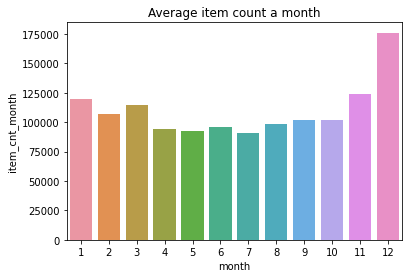

In [ ]:
m = [3,3,3,3,3,3,3,3,3,3,2,2]
mean_month = pd.DataFrame(sales.groupby(sales.date.dt.month)['item_cnt_day'].sum()/ m).reset_index(level = [0])
mean_month.columns = ['month', 'item_cnt_month']
sns.barplot(x='month', y='item_cnt_month', data=mean_month)
plt.title('Average item count a month')
plt.show()

December is clearly the 'leader'

# Merge all

In [ ]:
data = pd.merge(sales, shops, on = 'shop_id')
data = pd.merge(data, items, on = 'item_id')
data = pd.merge(data, categories, on = 'item_category_id' )
len(data)

2935849

In [ ]:
id_cols = ['shop_id', 'item_id', 'item_category_id']
num_cols = ['date_block_num', 'item_price', 'item_cnt_day']
cat_cols = ['city', 'cat']

In [ ]:
data.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154       999.0             1   
1 2013-01-02               0       25    22154       999.0             1   
2 2013-01-03               0       25    22154       999.0             1   
3 2013-01-20               0       25    22154       999.0             1   
4 2013-01-23               0       25    22154       999.0             1   

                shop_name       city          item_name  item_category_id  \
0  Ярославль ТЦ "Альтаир"  Ярославль  ЯВЛЕНИЕ 2012 (BD)                37   
1     Москва ТРК "Атриум"     Москва  ЯВЛЕНИЕ 2012 (BD)                37   
2     Москва ТРК "Атриум"     Москва  ЯВЛЕНИЕ 2012 (BD)                37   
3     Москва ТРК "Атриум"     Москва  ЯВЛЕНИЕ 2012 (BD)                37   
4     Москва ТРК "Атриум"     Москва  ЯВЛЕНИЕ 2012 (BD)                37   

  item_category_name   cat  sub_cat  
0     Кино - Blu-Ray  Кино  Blu-Ray  
1     Кино - Blu-Ray  Кино  Blu-Ray  
2     Кино - Blu-Ray  Кино  Blu-Ray  
3     Кино - Blu-Ray  Кино  Blu-Ray  
4     Кино - Blu-Ray  Кино  Blu-Ray

# Fill missing months with 0


In [ ]:
month_count_item = pd.DataFrame(sales.groupby(['item_id','shop_id', 'date_block_num'])['item_cnt_day'].sum()).reset_index(level = [0,1,2])
month_count_item.columns = ['item_id', 'shop_id', 'date_block_num', 'item_cnt_month']
len(month_count_item)                                                                                                                      

1609124

In [ ]:
it_index = []
sh_index = []
sh_len = len(shops)
date = []
for i in range(len(items)):
    it_index += [i]*(34 * sh_len)
    sh_index += list(range(sh_len))* 34
    date += list(range(34)) * sh_len

In [ ]:
full_record_month = pd.merge(
    pd.DataFrame({
    'item_id' : it_index,
    'shop_id': sh_index,
    'date_block_num' : date
}), month_count_item, how = 'left', on = ['item_id','shop_id', 'date_block_num'] )
full_record_month = full_record_month.fillna(0)
full_record_month.sample(10)

item_id  shop_id  date_block_num  item_cnt_month
8576538      4204       18               4             0.0
18451059     9044       39               7             0.0
21201972    10393       12              14             0.0
7717968      3783       48               2             0.0
5113622      2506        2              22             0.0
42884007    21021       27              11             0.0
11689899     5730       39              19             0.0
18613362     9124       42              28             0.0
36165726    17728        6              28             0.0
5722544      2805       44               4             0.0

# Most selling categories

In [ ]:
cat_total = data.groupby('cat')['item_cnt_day'].sum()

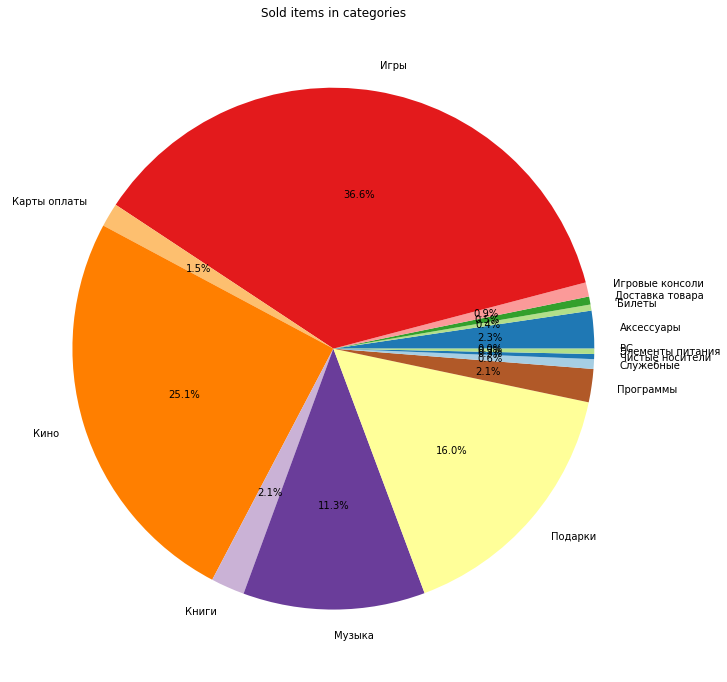

In [ ]:
plt.figure(figsize=(12,12))
colors = sns.color_palette('Paired')[:len(cat_total)]
plt.pie(cat_total, labels = cat_total.index, autopct = '%0.1f%%', colors = colors)
plt.title('Sold items in categories')
plt.show()

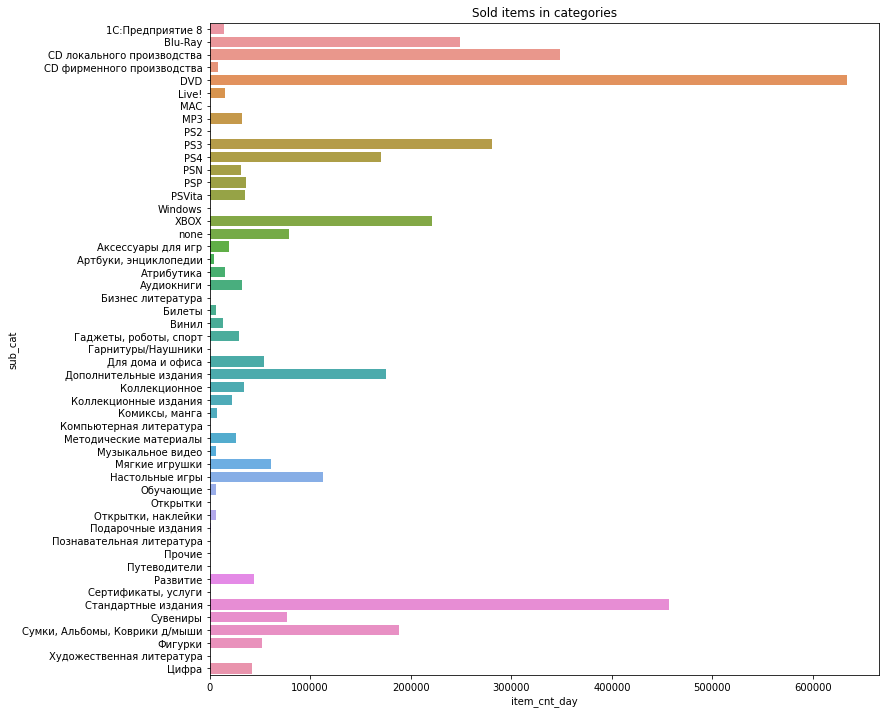

In [ ]:
sub_cat_total = data.groupby('sub_cat')['item_cnt_day'].sum()
plt.figure(figsize=(12,12))
sns.barplot(x = sub_cat_total, y = sub_cat_total.index)
plt.title('Sold items in categories')
plt.show()

In [ ]:
def min_max_cat(name):
    cat_price = data.groupby(name)['item_price'].describe()
    cat_price = cat_price[['min','mean', 'max']]
    cat_price = cat_price.reset_index(level=[0])
    return cat_price

In [ ]:
cat_price = min_max_cat('cat')
sub_cat_price = min_max_cat('sub_cat')
cats = pd.unique(categories.cat)
sub_cats = pd.unique(categories.sub_cat)

In [ ]:
data.groupby('cat')['sub_cat'].nunique().sum()

69

In [ ]:
def plot_cats(cat_price, categ, rows):
    plt.subplots_adjust(wspace = 2)
    for i in range(len(categ)):
        plt.subplot(rows,len(categ)//(rows - 1), i+1)
        sns.barplot(x = cat_price.columns[1:], y = cat_price.iloc[i,1:])
        plt.title(cat_price.iloc[i,0])
    plt.show()

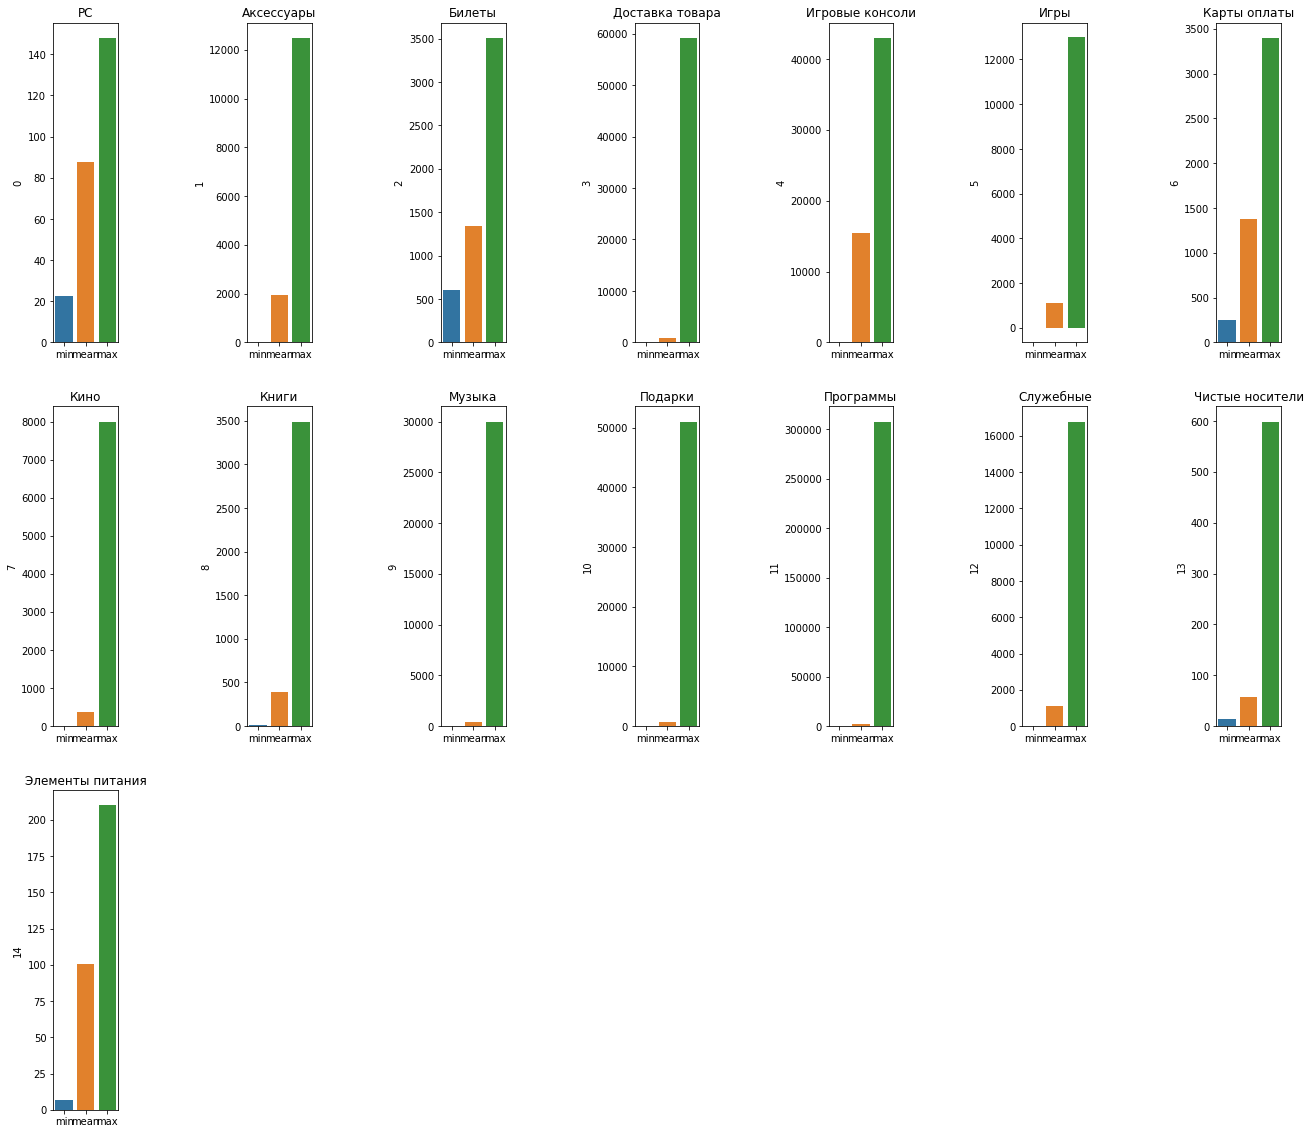

In [ ]:
plt.figure(figsize=(22,20))
plot_cats(cat_price, cats, 3)

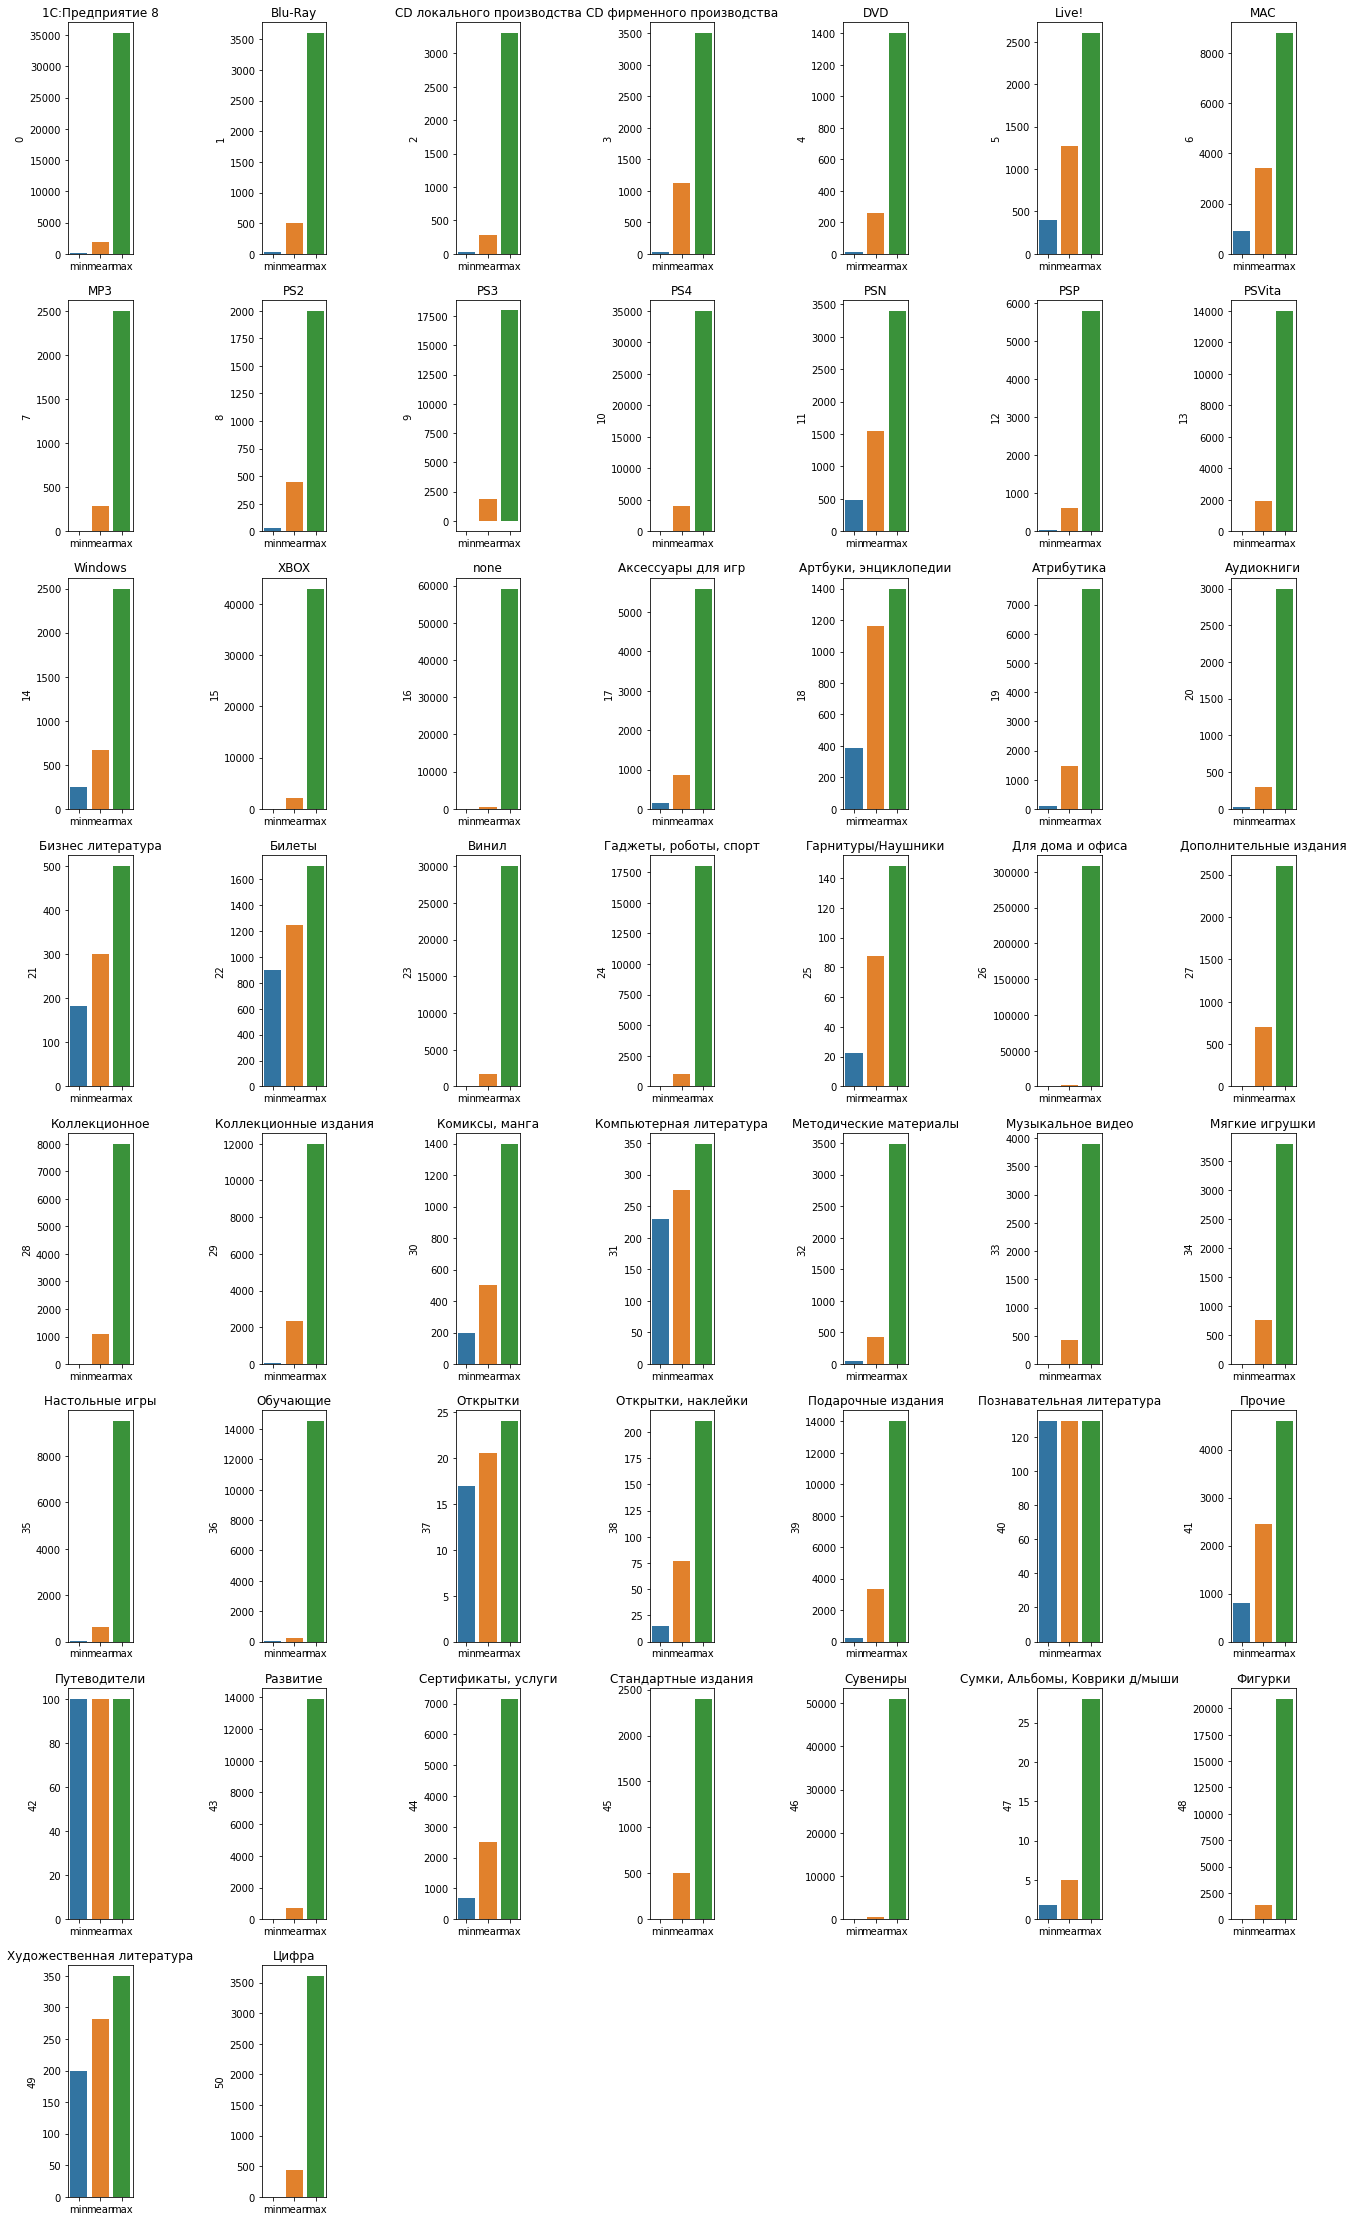

In [ ]:
plt.figure(figsize=(22,40))
plot_cats(sub_cat_price,sub_cats, 8)

# How price affects total count

In [ ]:
item_cnt = pd.DataFrame(data[data.date_block_num >= 24].groupby('item_id')['item_cnt_day'].sum()).reset_index(level = [0])
item_cnt.columns = ['item_id', 'item_cnt_month']
item_cnt.describe([.25, .5, .75, .95]).drop('item_id', axis = 1)

item_cnt_month
count    11249.000000
mean        67.969064
std        422.051274
min         -1.000000
25%          2.000000
50%         11.000000
75%         52.000000
95%        271.600000
max      38606.000000

In [ ]:
item_price_mean = pd.DataFrame(data[data.date_block_num >= 24].groupby('item_id')['item_price'].mean()).reset_index(level = [0])
temp = pd.merge(item_cnt, item_price_mean, on = 'item_id')

temp.columns = ['item_id', 'item_cnt_total', 'item_price']

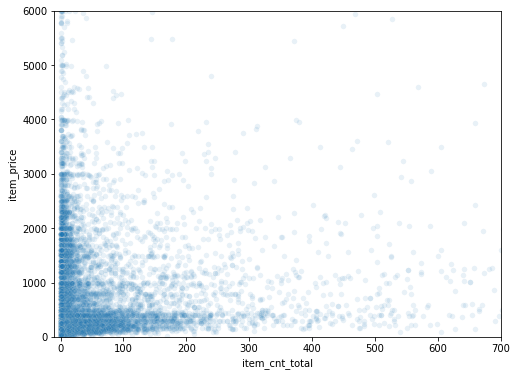

In [ ]:
plt.figure(figsize=(8,6))
sc = sns.scatterplot(x = temp.item_cnt_total, y = temp.item_price, x_bins = [0, 50, 100], alpha = 0.1, s = 30)
sc.set_xlim(left=-10, right=700)
sc.set_ylim(bottom=0, top=6000);

# Total sells through time

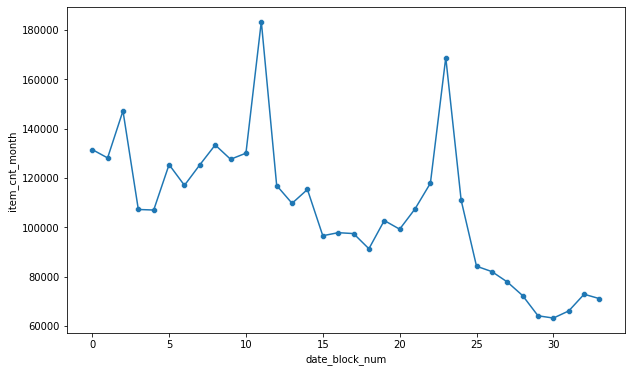

In [ ]:
temp = data.groupby('date_block_num')['item_cnt_day'].sum()
temp.name = 'item_cnt_month'
plt.figure(figsize=(10,6))
sns.scatterplot(y = temp,x = temp.index)
plt.plot(temp.index, temp)
plt.show()

# Count months for each item

In [ ]:
month_count_item = pd.DataFrame(sales.groupby(['item_id', 'date_block_num'])['item_cnt_day'].sum()).reset_index(level = [0,1])
month_count_item.columns = ['item_id', 'date_block_num', 'item_cnt_month']

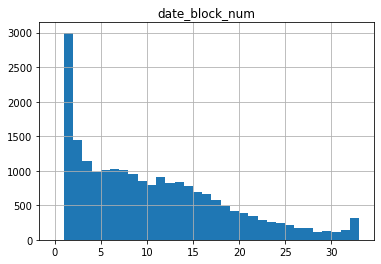

In [ ]:
item_month = pd.DataFrame(month_count_item.groupby('item_id')['date_block_num'].count())
item_month.hist(bins = list(range(34)))
plt.show()

In [ ]:
len(item_month), len(items)

(21807, 22170)

In [ ]:
item_month.columns = ['month_count']
item_month.reset_index(level = [0])
temp  = pd.merge(items, item_month, how = 'left', on = 'item_id')
item_month = temp.fillna(0)

In [ ]:
not_sold_items = item_month[item_month.month_count == 0].month_count

In [ ]:
test_data = pd.read_csv('test.csv')

In [ ]:
test_data[test_data.item_id.isin(not_sold_items.index)]

ID  shop_id  item_id
1            1        5     5320
4            4        5     5268
45          45        5     5826
64          64        5     3538
65          65        5     3571
...        ...      ...      ...
214130  214130       45    15033
214150  214150       45     7572
214154  214154       45     9030
214161  214161       45     1867
214173  214173       45    12470

[15246 rows x 3 columns]

363 items were not sold at all

# Dollar influence

In [ ]:
price_time_mean = sales.groupby('date_block_num')['item_price'].mean()
price_time_median = sales.groupby('date_block_num')['item_price'].median()
price_time_mean = pd.DataFrame(price_time_mean).reset_index(level=[0])
price_time_median = pd.DataFrame(price_time_median).reset_index(level=[0])

In [ ]:
def plot(a,b):
    plt.figure(figsize=(10,6))
    sns.scatterplot(y = a,x = a.index)
    plt.plot(a.index, a)
    sns.scatterplot(y = b,x =b.index)
    plt.plot(b.index, b)
    plt.show()

In [ ]:
rub = pd.read_csv('rub.csv').reset_index(level=[0])
rub.rub = [float(x.split(' ')[0]) for x in rub.rub]
rub.columns=['date_block_num', 'rub']

In [ ]:
data_month = pd.DataFrame(data.groupby('date_block_num')['item_cnt_day'].sum())
data_month.columns = ['item_cnt_month']
data_month = data_month.reset_index([0])
a = pd.merge(data_month, rub, on = 'date_block_num')
b = pd.merge(a, price_time_mean)

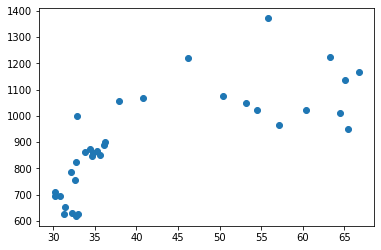

In [ ]:
plt.scatter(rub.rub, price_time_mean.item_price)

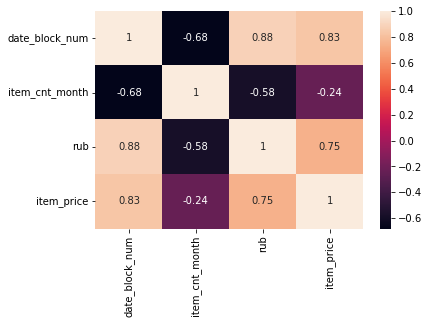

In [ ]:
sns.heatmap(b.corr(), annot=True)

In [ ]:
cat_count = data.groupby(['cat', 'date_block_num'])[['item_cnt_day']].sum().reset_index([0,1])
temp = data.groupby(['cat', 'date_block_num'])[['item_price']].mean().reset_index([0,1])
#

In [ ]:
cat_count = pd.merge(cat_count, temp, on = ['date_block_num', 'cat'])
cat_count = cat_count.groupby('cat')

In [ ]:
for i, c in enumerate(cats):
    t = cat_count.get_group(c)
    t = pd.merge(t,rub, on = 'date_block_num', how = 'outer').fillna(0)
    print(c)
    print(t.corr())
    print()

PC
                date_block_num  item_cnt_day  item_price       rub
date_block_num        1.000000     -0.480916   -0.429580  0.882056
item_cnt_day         -0.480916      1.000000    0.852494 -0.293191
item_price           -0.429580      0.852494    1.000000 -0.255823
rub                   0.882056     -0.293191   -0.255823  1.000000

Аксессуары
                date_block_num  item_cnt_day  item_price       rub
date_block_num        1.000000     -0.230732    0.907564  0.882056
item_cnt_day         -0.230732      1.000000   -0.122433 -0.201757
item_price            0.907564     -0.122433    1.000000  0.880850
rub                   0.882056     -0.201757    0.880850  1.000000

Билеты
                date_block_num  item_cnt_day  item_price       rub
date_block_num        1.000000      0.291094    0.657761  0.882056
item_cnt_day          0.291094      1.000000    0.550723  0.208435
item_price            0.657761      0.550723    1.000000  0.443410
rub                   0.882056      0.2

# Mean price in categories through time

In [ ]:
m = pd.DataFrame({'date_block_num' : list(range(34))})

In [ ]:
def plot_cat_time(cat_time, cats, name, cat_name):
    for i, c in enumerate(cats):
        t = cat_time[cat_time[cat_name] == c]
        t = pd.merge(t,m, on = 'date_block_num', how = 'right').fillna(0)
        plt.subplot(len(cats)//2 + 1,2, i+1)
        sns.scatterplot(x = t.date_block_num,y = t[name])
        plt.plot( t.date_block_num, t[name])
        plt.title(c)

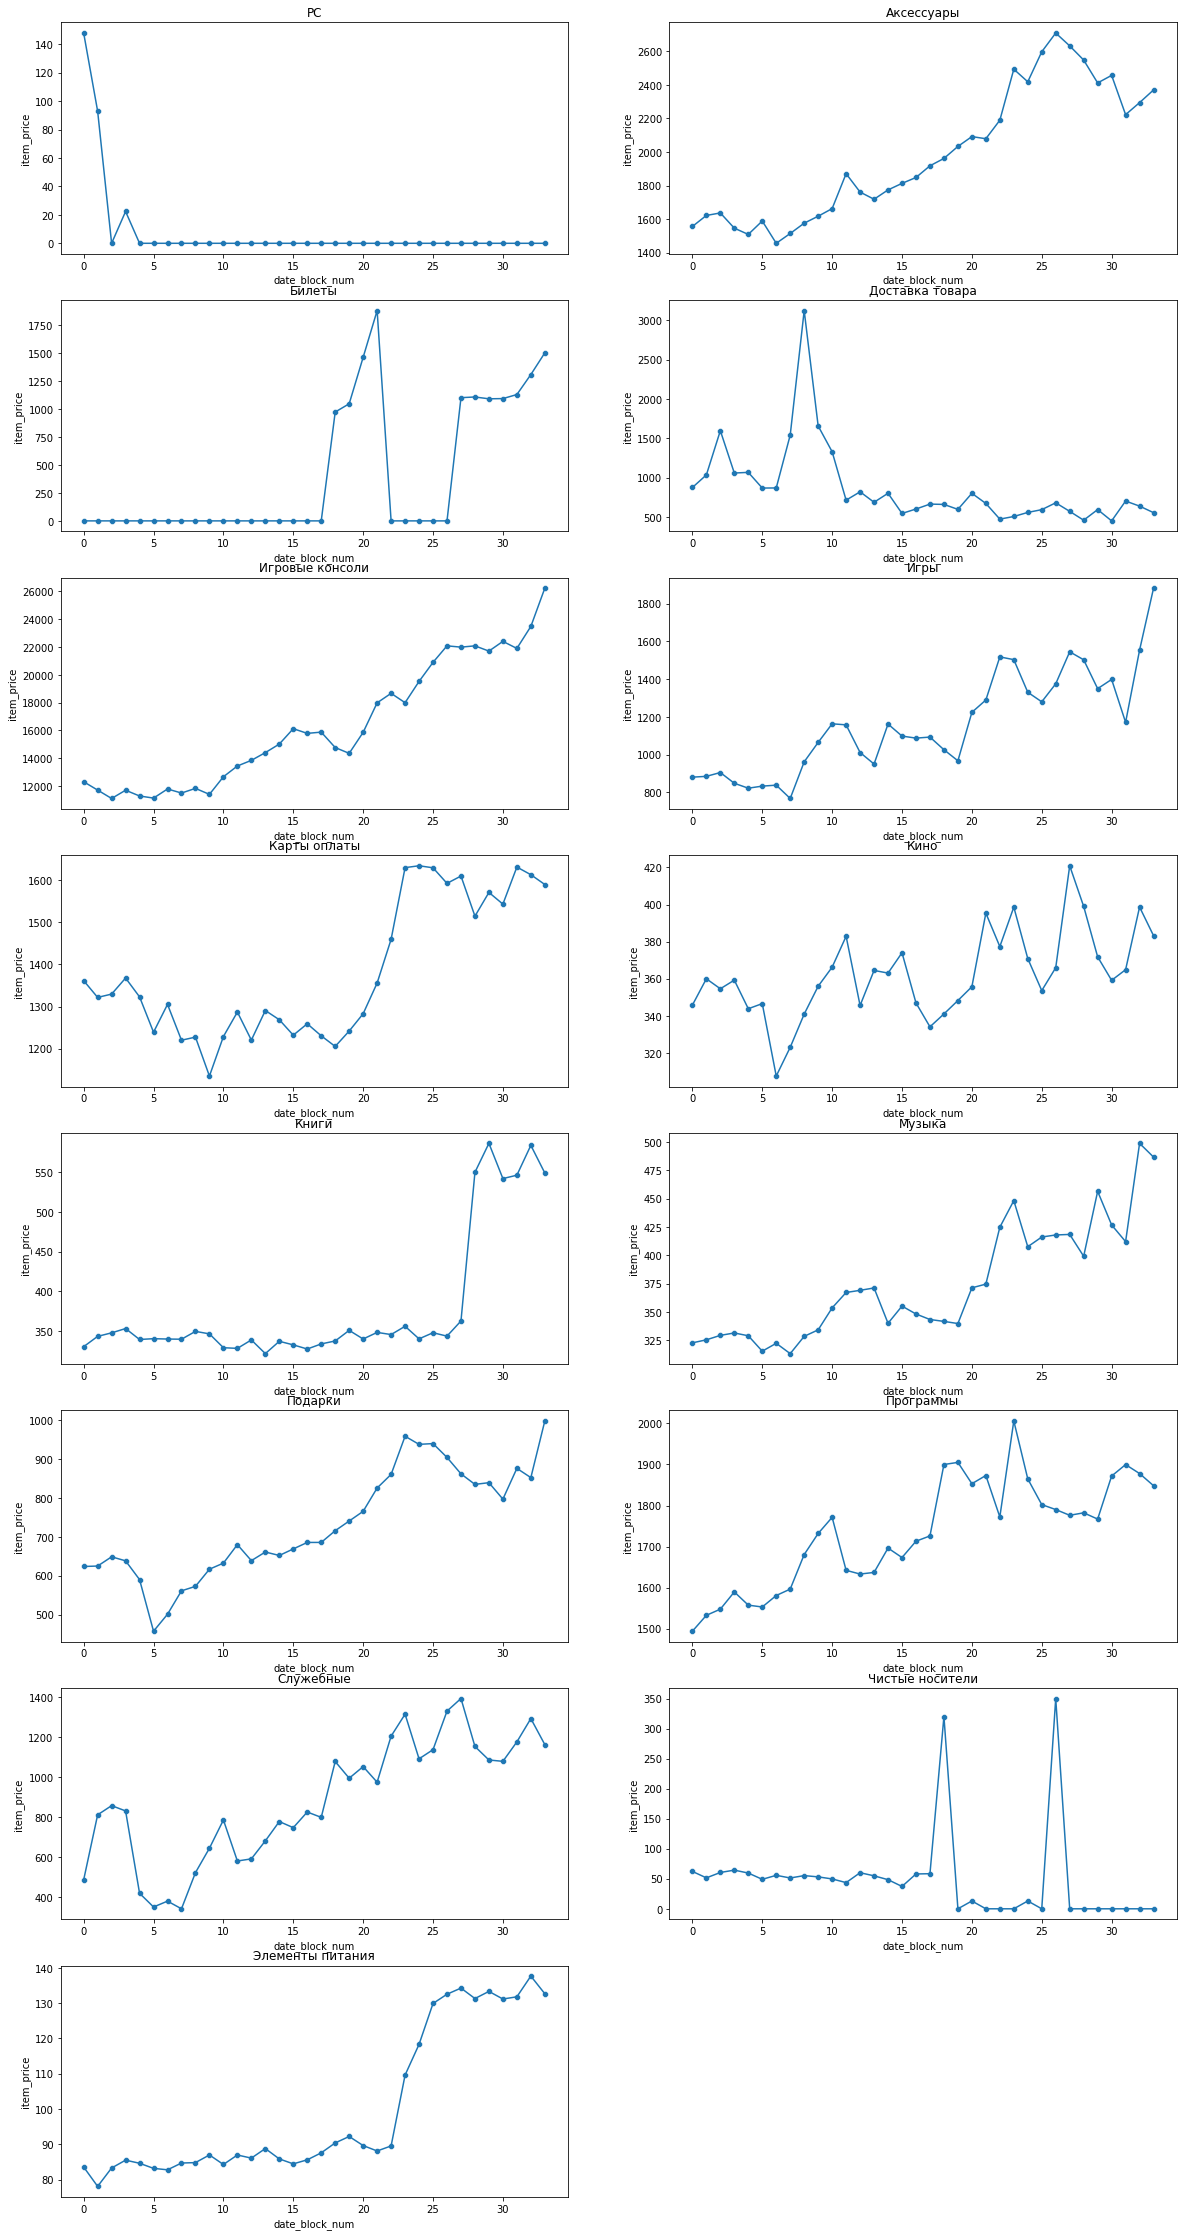

In [ ]:
cat_time = pd.DataFrame(data.groupby(['cat','date_block_num'])['item_price'].mean()).reset_index(level=[0,1])
plt.figure(figsize=(20,40))
plot_cat_time(cat_time, cats, 'item_price', 'cat')

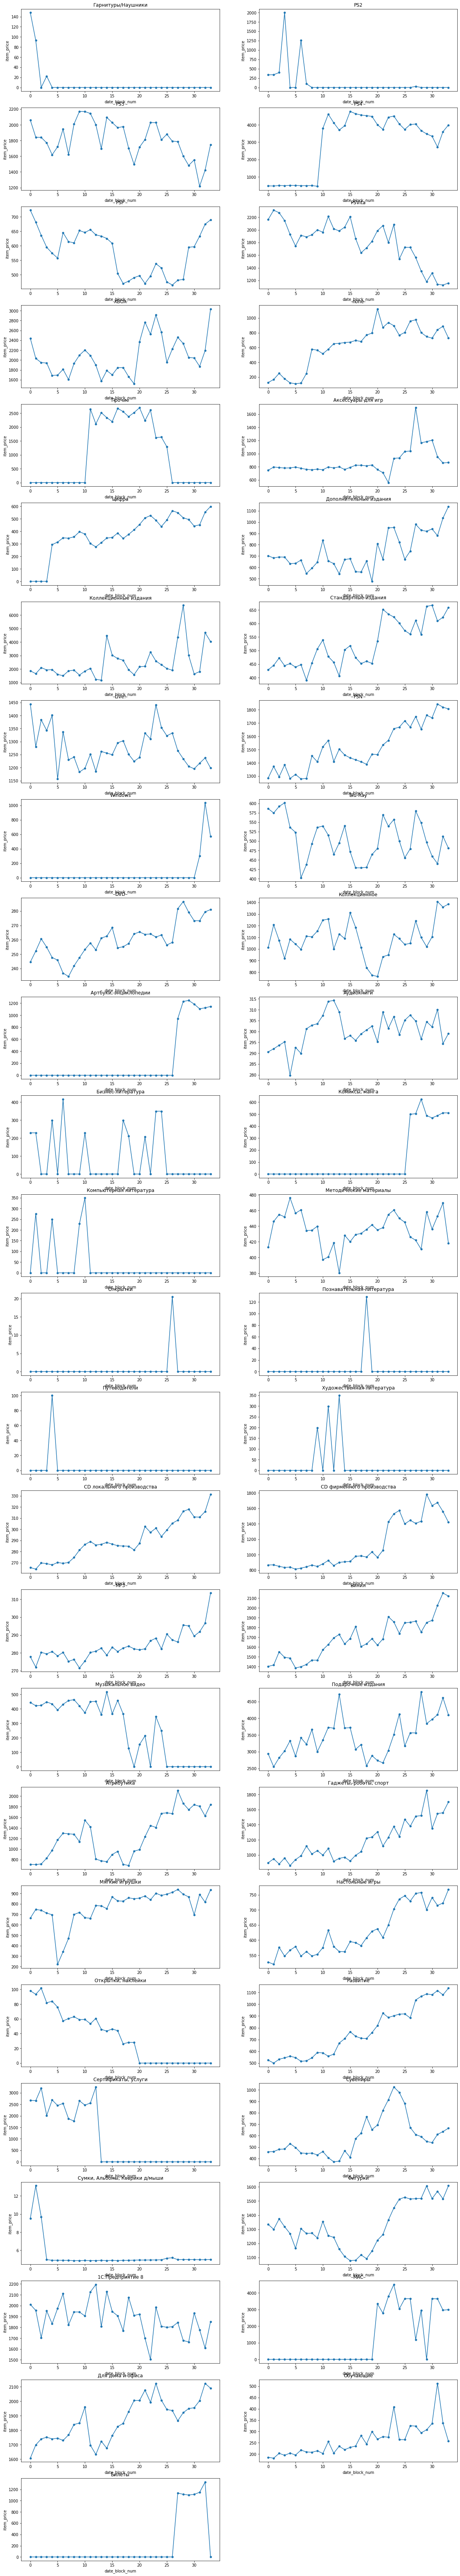

In [ ]:
cat_time = pd.DataFrame(data.groupby(['sub_cat','date_block_num'])['item_price'].mean()).reset_index(level=[0,1])
plt.figure(figsize=(20,120))
plot_cat_time(cat_time, sub_cats, 'item_price', 'sub_cat')

# item_count_month in categories through time

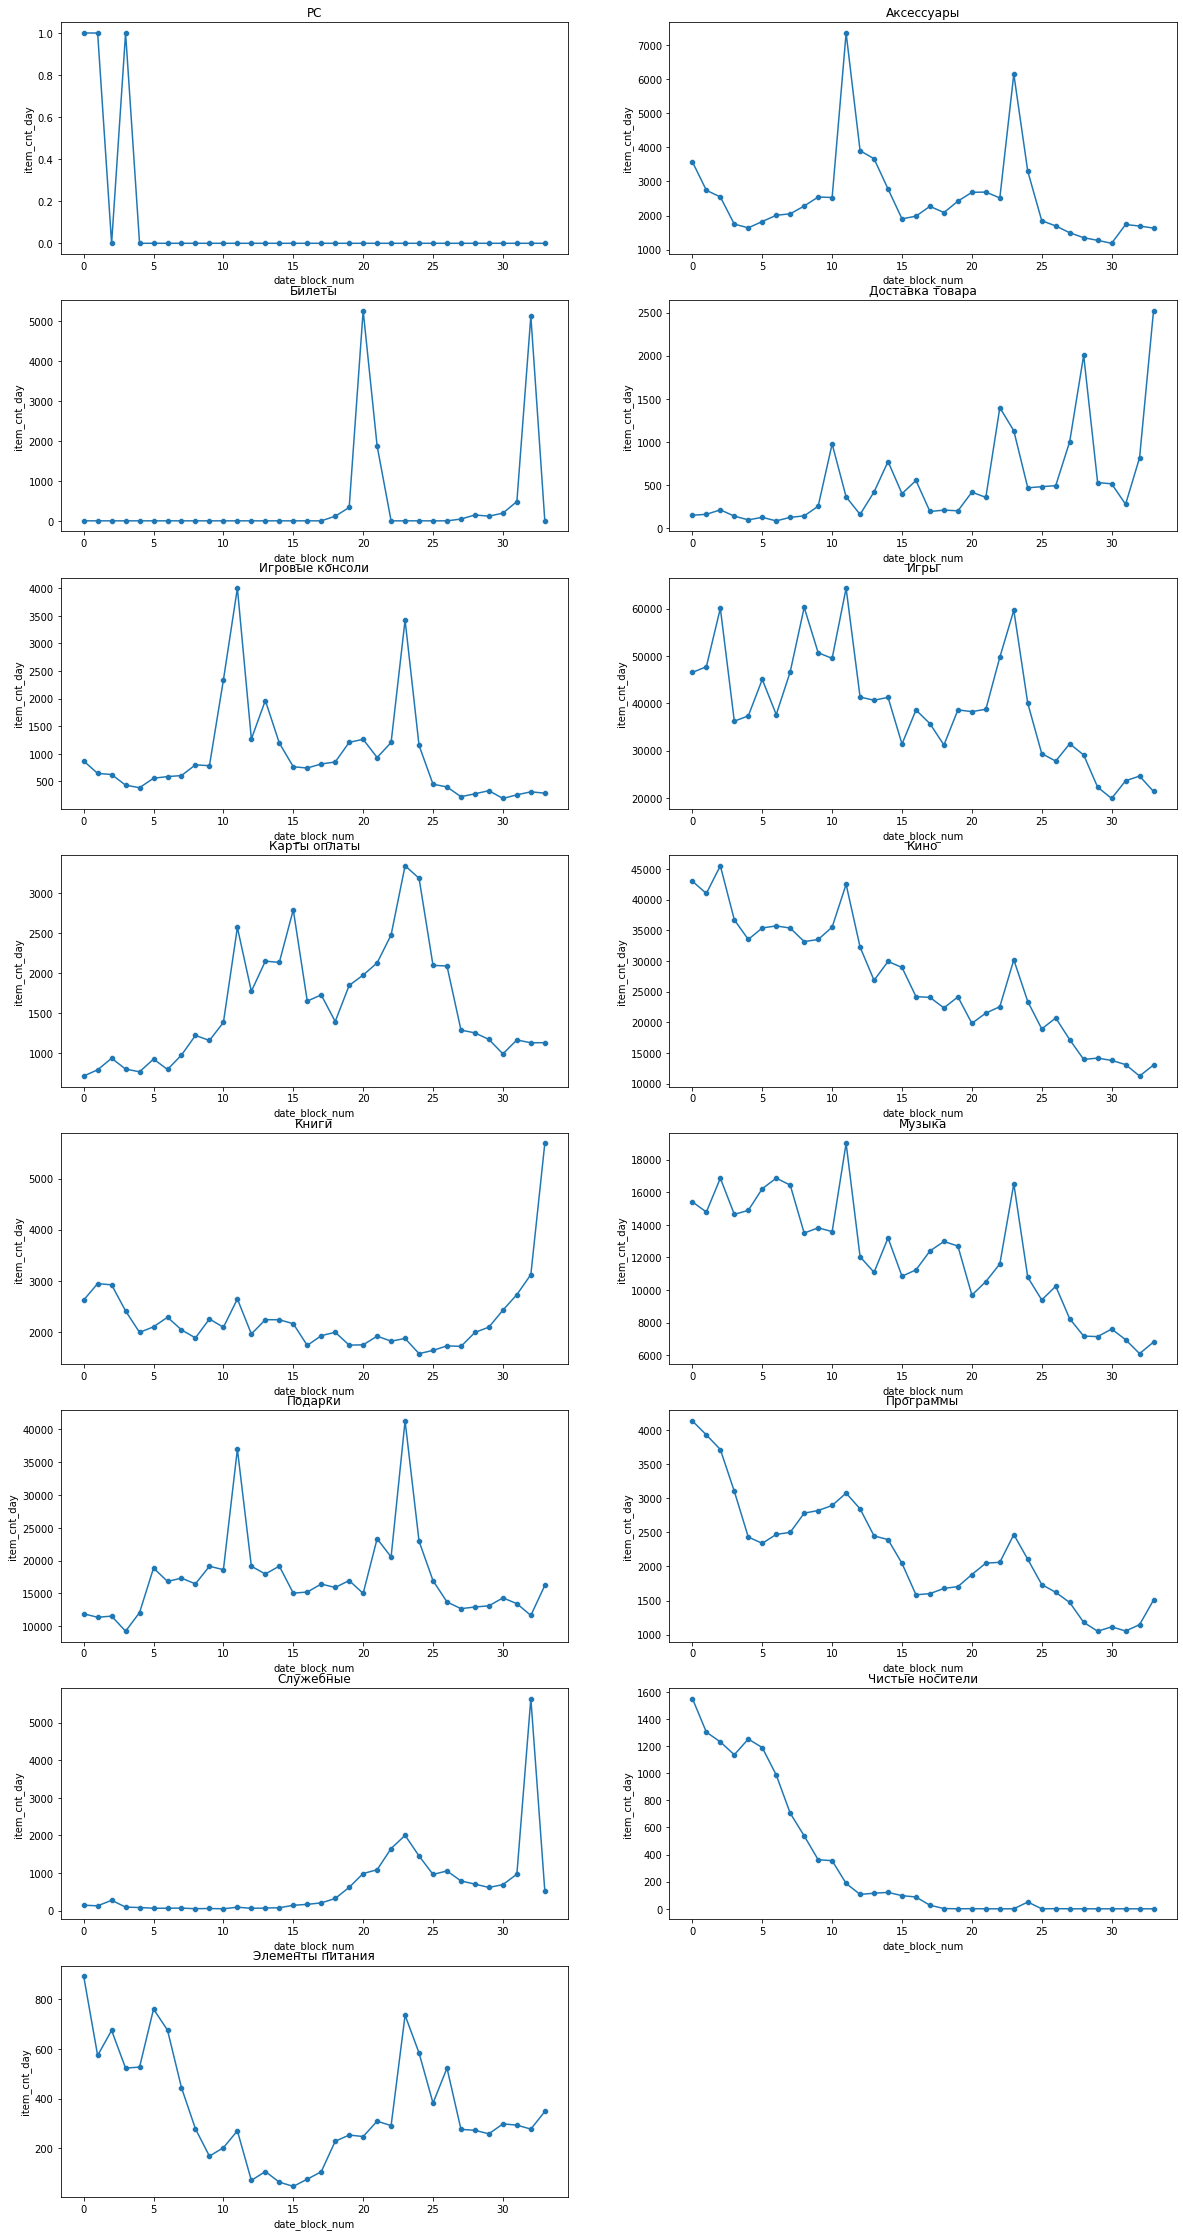

In [ ]:
cat_time = pd.DataFrame(data.groupby(['cat','date_block_num'])['item_cnt_day'].sum()).reset_index(level=[0,1])
plt.figure(figsize=(20,40))
plot_cat_time(cat_time, cats, 'item_cnt_day', 'cat')

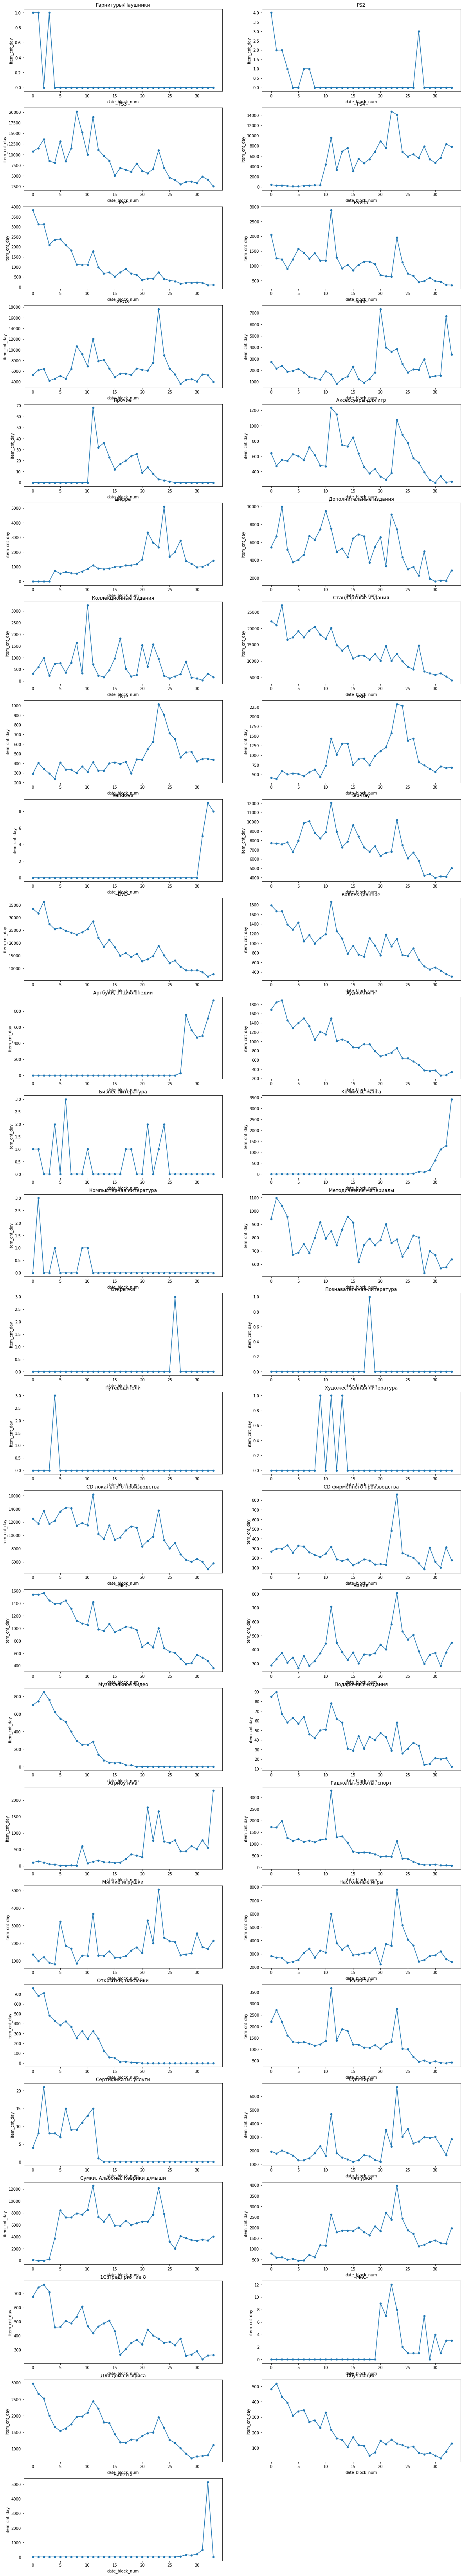

In [ ]:
cat_time = pd.DataFrame(data.groupby(['sub_cat','date_block_num'])['item_cnt_day'].sum()).reset_index(level=[0,1])
plt.figure(figsize=(20,120))
plot_cat_time(cat_time, sub_cats, 'item_cnt_day', 'sub_cat')

# Shops opened/closed

In [ ]:
first_date_shop = pd.DataFrame(sales.groupby('shop_id')['date'].min()).reset_index([0]).sort_values('date')
last_date_shop = pd.DataFrame(sales.groupby('shop_id')['date'].max()).reset_index([0]).sort_values('date')

In [ ]:
last_date_shop[last_date_shop.date < datetime(2015, 10, 30)]

shop_id       date
0         0 2013-02-28
1         1 2013-02-28
8         8 2013-04-01
23       23 2013-04-28
32       32 2013-07-03
13       13 2014-08-09
17       17 2015-01-18
43       43 2015-01-25
40       40 2015-01-29
30       30 2015-02-18
11       11 2015-02-28
54       54 2015-04-23
33       33 2015-04-24
29       29 2015-05-28
51       51 2015-09-28
27       27 2015-09-30
20       20 2015-10-04
9         9 2015-10-14

In [ ]:
closed_shops = last_date_shop[last_date_shop.date < datetime(2015, 10, 30)].shop_id
test_data[test_data.shop_id.isin(closed_shops)]

Empty DataFrame
Columns: [ID, shop_id, item_id]
Index: []

# Correlation between months

In [ ]:
m = pd.DataFrame({'date_block_num':list(range(34))})

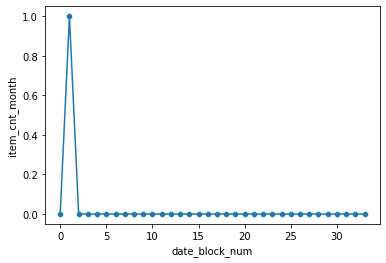

In [ ]:
sample = data[data.item_id == items.sample().iloc[0,1]]

sample = pd.DataFrame(sample.groupby('date_block_num')['item_cnt_day'].sum()).reset_index([0])


a = pd.merge(sample,m, on = 'date_block_num', how = 'right').fillna(0)
a.columns = ['date_block_num', 'item_cnt_month']

sns.scatterplot(x = a.date_block_num,y = a.item_cnt_month)
plt.plot( a.date_block_num, a.item_cnt_month)

In [ ]:
data_item_month = pd.DataFrame(data.groupby(['item_id','date_block_num'])['item_cnt_day'].sum()).reset_index([0])
data_item_shop = pd.DataFrame(data.groupby(['item_id', 'shop_id','date_block_num'])['item_cnt_day'].sum()).reset_index([0,1])

In [ ]:
it_ind = []
sh_ind = []
s = len(shops)
for i in items.item_id:
    it_ind += [i]*s
    sh_ind += list(range(s))
    

In [ ]:
temp = pd.DataFrame({'item_id' : it_ind, 'shop_id': sh_ind})

In [ ]:
for i in range(33):
    l = [i,i+1]
    sample = data_item_shop[data_item_shop.index.isin(l)]
    sample = sample.reset_index()

    data_32 = sample.groupby('date_block_num').get_group(l[0])
    data_33 = sample.groupby('date_block_num').get_group(l[1])
    data_32 = pd.merge(data_32, temp, how = 'right', on = ['item_id', 'shop_id']).fillna(0)
    
    data_33 = pd.merge(data_33, temp, how = 'right', on = ['item_id', 'shop_id']).fillna(0)
    a = pd.merge(data_32, data_33, on=['item_id', 'shop_id'], how='outer').drop(['date_block_num_x','item_id', 'shop_id', 'date_block_num_y' ], axis = 1)
    print(i, '-', i + 1)
    print(a.corr().iloc[0,1])
    print()

0 - 1
0.5123497574168642

1 - 2
0.39451851154138795

2 - 3
0.513122227599586

3 - 4
0.37406092461222135

4 - 5
0.6583814874314036

5 - 6
0.8718697187845991

6 - 7
0.8329817331595433

7 - 8
0.6736126966051706

8 - 9
0.7585994176947787

9 - 10
0.7616243569723607

10 - 11
0.8443037386305209

11 - 12
0.8714777410625631

12 - 13
0.8818715625423283

13 - 14
0.7987093932617239

14 - 15
0.6430558026234869

15 - 16
0.6335772336577145

16 - 17
0.8073289944017289

17 - 18
0.8563969667811362

18 - 19
0.8831851826427839

19 - 20
0.6322582626046994

20 - 21
0.6561961092356343

21 - 22
0.5263859853661168

22 - 23
0.8437844398153709

23 - 24
0.7309221899251336

24 - 25
0.4839422930108081

25 - 26
0.560640413508373

26 - 27
0.2416577337693405

27 - 28
0.39503095317061926

28 - 29
0.6844487691220489

29 - 30
0.8678573324690162

30 - 31
0.8225848003433378

31 - 32
0.4244392421650939

32 - 33
0.18507763752061882



In [ ]:
indexes = pd.DataFrame({'item_id' : items.item_id})

In [ ]:
for i in range(33):
    l = [i, i + 1]
    sample = data_item_month[data_item_month.index.isin(l)]
    sample = sample.reset_index()
    
    data_32 = sample.groupby('date_block_num').get_group(l[0])
    data_33 = sample.groupby('date_block_num').get_group(l[1])
    data_32 = pd.merge(data_32, indexes, how = 'right', on = 'item_id').fillna(0)
    data_33 = pd.merge(data_33, indexes, how = 'right', on = 'item_id').fillna(0)
    a = pd.merge(data_32, data_33, on='item_id', how='outer').drop(['date_block_num_x','item_id', 'date_block_num_y' ], axis = 1)
    print(i, '-', i + 1)
    print(a.corr().iloc[0,1])
    print()

0 - 1
0.5918109437865451

1 - 2
0.4350900574421502

2 - 3
0.5963565887243144

3 - 4
0.45154249589703827

4 - 5
0.7689621114147575

5 - 6
0.9487386520508472

6 - 7
0.9013116619198701

7 - 8
0.6612462781996411

8 - 9
0.838617542384033

9 - 10
0.7999828531996969

10 - 11
0.8991372498839351

11 - 12
0.9717371814690818

12 - 13
0.9447006321337739

13 - 14
0.8745053557361573

14 - 15
0.7746763145906296

15 - 16
0.776892287088494

16 - 17
0.925392097223444

17 - 18
0.9114657658131542

18 - 19
0.9449448591808117

19 - 20
0.7417429650123355

20 - 21
0.8164790305910969

21 - 22
0.7440861509326456

22 - 23
0.8720421136754347

23 - 24
0.962129458940617

24 - 25
0.8592309623780767

25 - 26
0.7892149460532365

26 - 27
0.3890927699155847

27 - 28
0.3649779358932307

28 - 29
0.7477885227931246

29 - 30
0.9310303441648774

30 - 31
0.9176272991118223

31 - 32
0.6947937919305647

32 - 33
0.6087731619536114



# Population

In [ ]:
population = pd.read_csv('population.csv', encoding="cp1251", delimiter=';')
population = pd.merge(population, shops[['city']], on='city', how='outer').drop_duplicates('city').fillna(0)
population 

city      pop
0             Якутск    299.0
4             Адыгея    449.0
5           Балашиха    260.0
6           Волжский    326.0
7            Вологда    318.0
8            Воронеж   1023.0
11         Жуковский    107.0
13            Казань   1205.0
15            Калуга    359.0
16           Коломна    144.0
17        Красноярск   1052.0
19             Курск    435.0
20            Москва  12197.0
33            Мытищи    187.0
34        Н.Новгород   1267.0
36       Новосибирск   1567.0
38              Омск   1173.0
39      РостовНаДону   1114.0
42               СПб   5191.0
44            Самара   1171.0
46           Сергиев    106.0
47            Сургут    340.0
48             Томск    564.0
49            Тюмень    697.0
52               Уфа   1105.0
54             Химки    232.0
55             Чехов     69.0
56         Ярославль    603.0
57          Выездная      0.0
58  Интернет-магазин      0.0
59          Цифровой      0.0

In [ ]:
city_month = data[data.date_block_num >=28].groupby(['date_block_num','city'])[['item_cnt_day']].sum().reset_index([0,1])
city_month = pd.merge(city_month, population, on = 'city', how = 'outer')
city_month.drop(['date_block_num'], axis = 1).corr()

item_cnt_day      pop
item_cnt_day       1.00000  0.91333
pop                0.91333  1.00000

In [ ]:
city_month = data[data.date_block_num >=28].groupby(['date_block_num','city', 'shop_id'])[['item_cnt_day']].sum().reset_index([0,1,2])
city_month = pd.merge(city_month, population, on = 'city', how = 'outer')
city_month.drop(['date_block_num', 'shop_id'], axis = 1).corr()

item_cnt_day       pop
item_cnt_day      1.000000  0.488646
pop               0.488646  1.000000

# Number of shops

In [ ]:
temp = data[data.date_block_num >=28].groupby(['city', 'date_block_num'])[['shop_id']].nunique()
temp.columns = ['shop_cnt']
temp = temp.reset_index([0,1])

In [ ]:
temp

city  date_block_num  shop_cnt
0       Адыгея               0         1
1       Адыгея               1         1
2       Адыгея               2         1
3       Адыгея               3         1
4       Адыгея               4         1
..         ...             ...       ...
968  Ярославль              29         1
969  Ярославль              30         1
970  Ярославль              31         1
971  Ярославль              32         1
972  Ярославль              33         1

[973 rows x 3 columns]

In [ ]:
pd.merge(city_month,temp, on = ['city', 'date_block_num'], how = 'outer').dropna().corr()

date_block_num  item_cnt_day       pop  shop_cnt
date_block_num        1.000000      0.004615 -0.004375 -0.011114
item_cnt_day          0.004615      1.000000  0.913330  0.927701
pop                  -0.004375      0.913330  1.000000  0.855084
shop_cnt             -0.011114      0.927701  0.855084  1.000000

# City - category

In [ ]:
temp = data.groupby(['city','cat' ])['item_cnt_day'].sum().reset_index([0,1])

In [ ]:
temp

city               cat  item_cnt_day
0       Адыгея        Аксессуары          1379
1       Адыгея            Билеты             4
2       Адыгея   Игровые консоли           534
3       Адыгея              Игры         18350
4       Адыгея      Карты оплаты           502
..         ...               ...           ...
377  Ярославль            Музыка          4832
378  Ярославль           Подарки          6557
379  Ярославль         Программы           922
380  Ярославль         Служебные           375
381  Ярославль  Элементы питания           534

[382 rows x 3 columns]

In [ ]:
cities = pd.unique(shops.city)

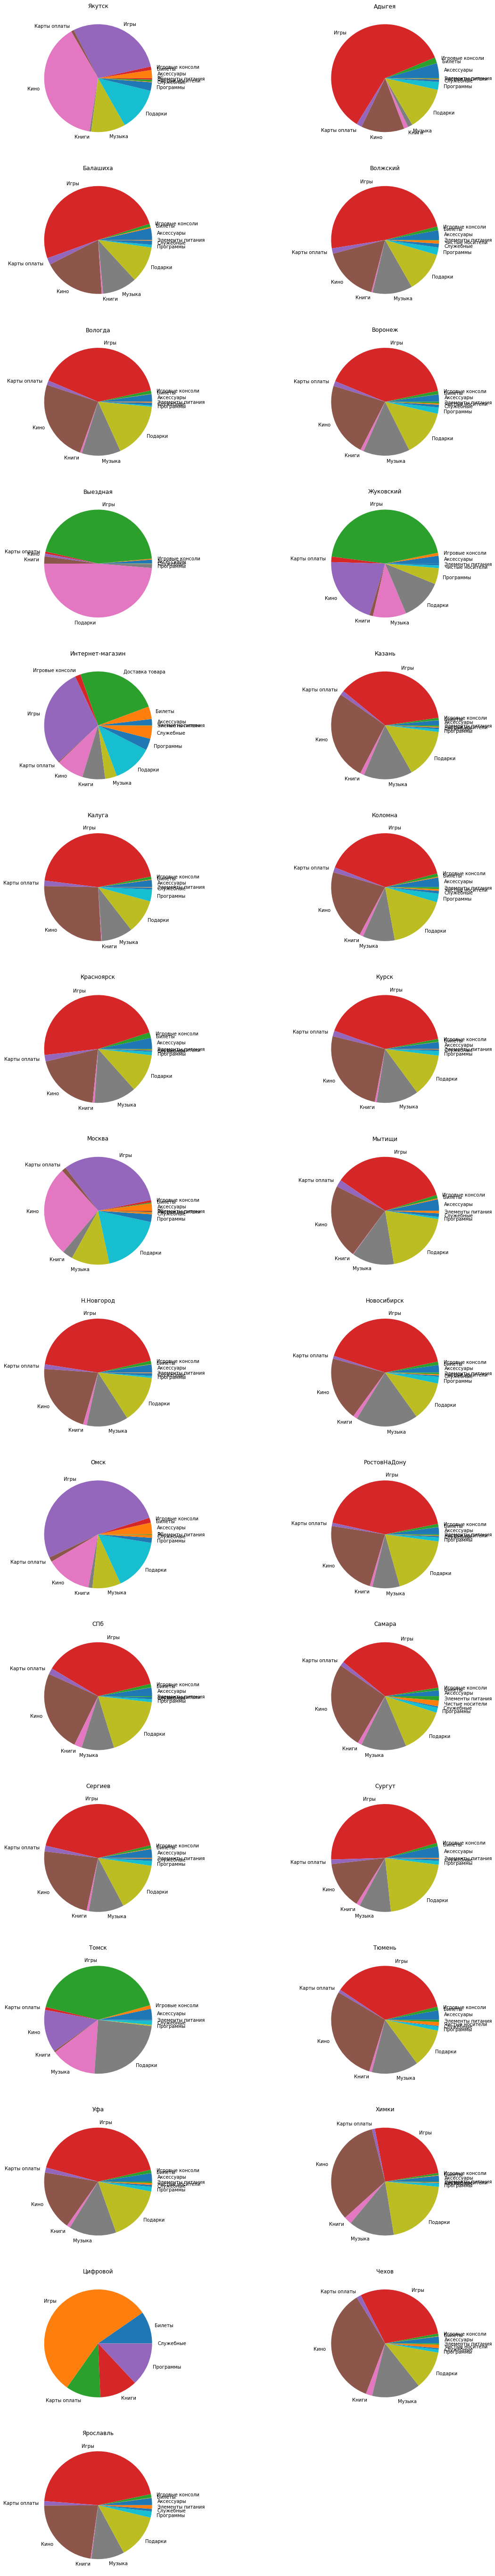

In [ ]:
plt.figure(figsize=(20,100))
for i, c in enumerate(cities):
        t = temp.groupby('city').get_group(c)
        plt.subplot(len(cities)//2 + 1,2, i+1)
        plt.pie(t.item_cnt_day,labels=t.cat)
        plt.title(c)

# Notes

* 363 items were not sold at all
a lot of items were sold only for a short period of time(1 month)
it is necessary to explore this items more carefully(probably we can devide them into categories)

* a lot of outliers in price column and item_cnt_day column
big value of item_cnt_day may be a sign of продажи оптом
they appear in almost all months

* some shops have very low sales number. it may be explained by different opening time. 
maybe a month of opening might be useful for predictions
* some categories have very low sales. it may make sense to unite them into one

* huge variance in price within every category 
the biggest variance is seen in categories with the highest sales. it may be explained by the variety of goods in this category
maybe it would make sence to divide them into smaller categories 

* overall sales tend to decrease an it is clear that there are peaks in december

* dollar correlates well with total item_cnt_month(sum for all items) and mean item_price
but we should be careful because it also correlates with date_block_num

* dollar affects different categories differently

* if we look at the random item count distribution through time we 
will notice that most items were sold only for a short period of time and most items have one peak
maybe we can cluster items by their sales distribution
cause you can notice some patterns and similarities

* some months have strong correlation in sales (min 0.35 max 0.97)
* some months have strong correlation in sales per shop

* some shops were opened after 2013*01 and some were closed before 2015*10
low correlation between some months can be explained by closed and opened shops

* population correlates well with total sells in a city as well as amount of shops in a city

